# **NOTEBOOK 1: EXPLORACIÓN INICIAL DEL DATASET**

### En este notebook inicial analizaremos las características de nuestro dataset, generando un informe de calidad de datos y estableciendo unos objetivos para el Notebook 2, consistente en la limpieza de los datos.

In [1]:
# Carga de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Carga de datos y primer vistazo

df = pd.read_csv('/Users/gestion/OneDrive/Desktop/churn/data/raw.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Podemos observar como la variable TotalCharges es de tipo object, cuando debería ser numérica.
También vemos que la mayoría de columnas empiezan por mayúscula, por lo que hay que transformarlas.

### Nulos

In [4]:
# Función para detectar nulos y valores faltantes

def detectar_nulos_personalizados(df, valores_nulos=None):
    if valores_nulos is None:
        valores_nulos = ['NA', 'Na', 'na', 'NN', 'nn', 'Nn', 'None', 
                        'NONE', 'none', 'N', 'n', '', ' ', '-']
    
    resultados = []
    
    for col in df.columns:
        nulos_standard = df[col].isnull().sum()
        
        nulos_personalizados = 0
        if df[col].dtype == 'object':
            nulos_personalizados = df[col].isin(valores_nulos).sum()
        
        total_nulos = nulos_standard + nulos_personalizados
        porcentaje = (total_nulos / len(df)) * 100
        
        resultados.append({
            'Columna': col,
            'Total_Nulos': total_nulos,
            'Porcentaje': round(porcentaje, 2)
        })
    
    df_nulos = pd.DataFrame(resultados)
    df_nulos = df_nulos.sort_values('Total_Nulos', ascending=False)
    df_nulos = df_nulos.reset_index(drop=True)
    
    return df_nulos

In [5]:
# Apliquemos la función para ver cuántos nulos hay

NULOS = ['NA', 'Na', 'na', 'NN', 'nn', 'Nn', 'None', 'NONE', 'none', 'N', 'n', '', ' ', '-']

resumen_nulos = detectar_nulos_personalizados(df, NULOS)

print(resumen_nulos[resumen_nulos['Total_Nulos'] > 0])

        Columna  Total_Nulos  Porcentaje
0  TotalCharges           11        0.16


Vemos que la columna TotalCharges tiene 11 nulos, lo cual es un 16% de los registros.

### Duplicados

In [6]:
duplicados = df.duplicated().sum()
print(f"Registros duplicados: {duplicados}")

# Verificar duplicados por customerID
duplicados_id = df['customerID'].duplicated().sum()
print(f"CustomerIDs duplicados: {duplicados_id}")

if duplicados_id > 0:
    print("\n🚨 PROBLEMA: Hay customerIDs duplicados")
    dups = df[df['customerID'].duplicated(keep=False)].sort_values('customerID')
    print(dups[['customerID', 'tenure', 'MonthlyCharges', 'Churn']].head(10))

Registros duplicados: 0
CustomerIDs duplicados: 0


No hay registros duplicados.

### Outliers en tenure

Vamos a analizar primero los outliers en la variable "tenure", ya que en la variable TotalCharge hay que realizar una transformación en el notebook posterior.

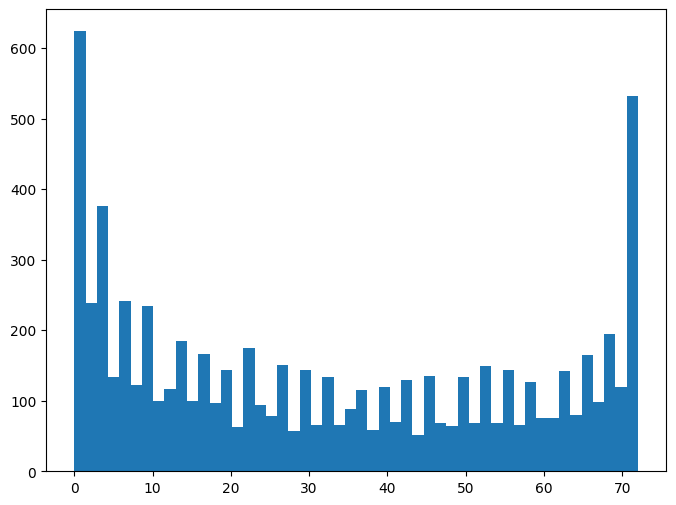

In [7]:
# Vemos la distribución de la variable para saber qué método usar

plt.figure(figsize = (8,6))
plt.hist(df['tenure'], bins=50)
plt.show()

Observamos que la variable tenure tiene una distribución bimodal, por lo que en vez de usar Z-Score (pensado para distribuciones normales), aplicaremos el método del IQR.

In [8]:
Q1 = df['tenure'].quantile(0.25)
Q3 = df['tenure'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['tenure'] < lower_bound) | (df['tenure'] > upper_bound)]

print(f'En la variable tenure hay {len(outliers)} outliers')

En la variable tenure hay 0 outliers


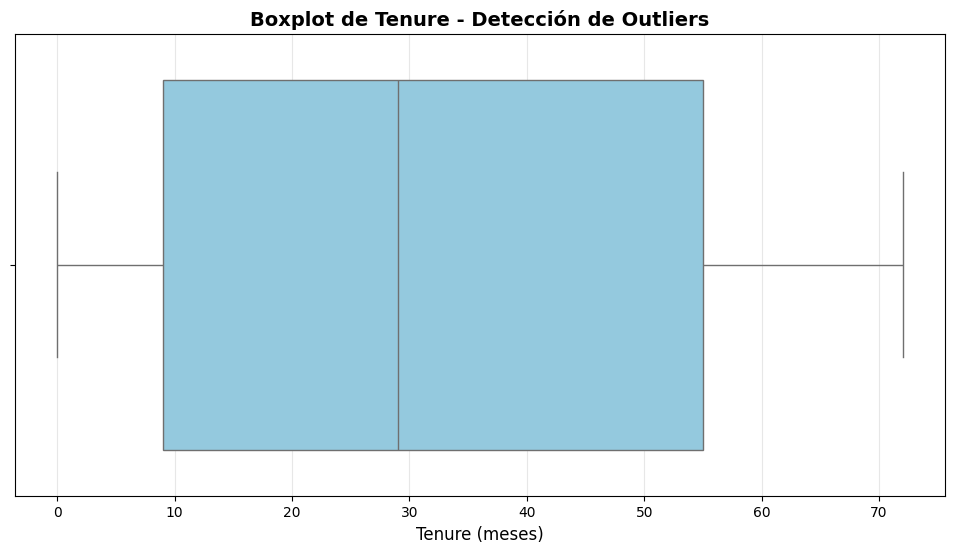

In [9]:
# Vamos a visualizarlo con un boxplot

import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['tenure'], color='skyblue')
plt.xlabel('Tenure (meses)', fontsize=12)
plt.title('Boxplot de Tenure - Detección de Outliers', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.show()

Como vemos, no existen outliers e la variable 'tenure'.

### Análisis de la variable objetivo "churn"

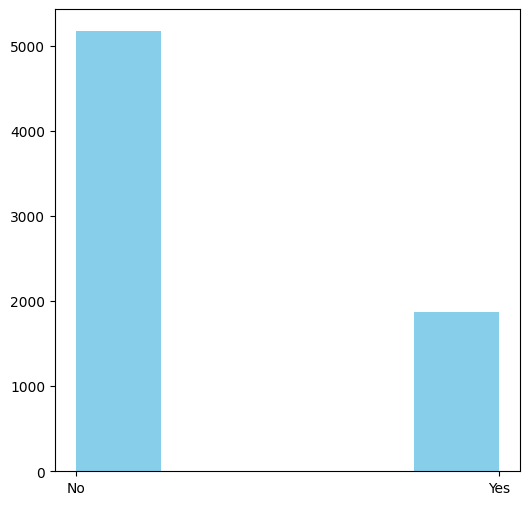

In [10]:
plt.figure(figsize=(6,6))
plt.hist(df['Churn'], bins = 5, color='SkyBlue')
plt.show()

In [11]:
conteo_churn = df['Churn'].value_counts()
conteo_churn_si = conteo_churn['Yes']
conteo_churn_no = conteo_churn['No']

print(f'El número total de clientes es {sum(conteo_churn)}.')
print(f'De todos ellos, abandonaron {conteo_churn_si}, lo que representa un {round(conteo_churn_si/len(df['Churn'])*100), 2} %')
print(f'De todos ellos, no abandonaron {conteo_churn_no}, lo que representa un {round(conteo_churn_no/len(df['Churn'])*100), 2} %')

El número total de clientes es 7043.
De todos ellos, abandonaron 1869, lo que representa un (27, 2) %
De todos ellos, no abandonaron 5174, lo que representa un (73, 2) %


In [12]:
# Analizamos el churn por género y por contrato

pd.crosstab(df['gender'], df['Churn'], normalize ='index')*100

Churn,No,Yes
gender,,
Female,73.079128,26.920872
Male,73.839662,26.160338


Los porcentajes de churn son prácticamente iguales para ambos géneros.

In [13]:
pd.crosstab(df['Contract'], df['Churn'], normalize ='index')*100

Churn,No,Yes
Contract,,
Month-to-month,57.290323,42.709677
One year,88.730482,11.269518
Two year,97.168142,2.831858


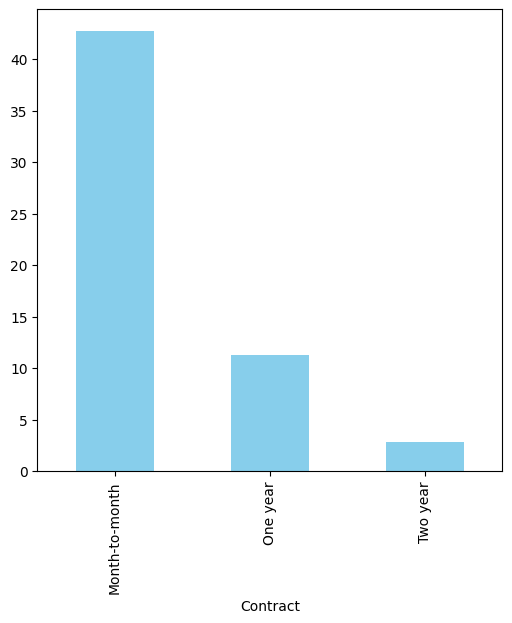

In [14]:
churn_por_contracto = df.groupby('Contract')['Churn'].apply(lambda x: (x=='Yes').sum()/len(x)*100)

plt.figure(figsize=(6,6))
churn_por_contracto.plot(kind='bar', color='SkyBlue')
plt.show()

A primera vista, vemos cómo cuanto mayor es la duración del contrato, menor es la tasa de abandono.

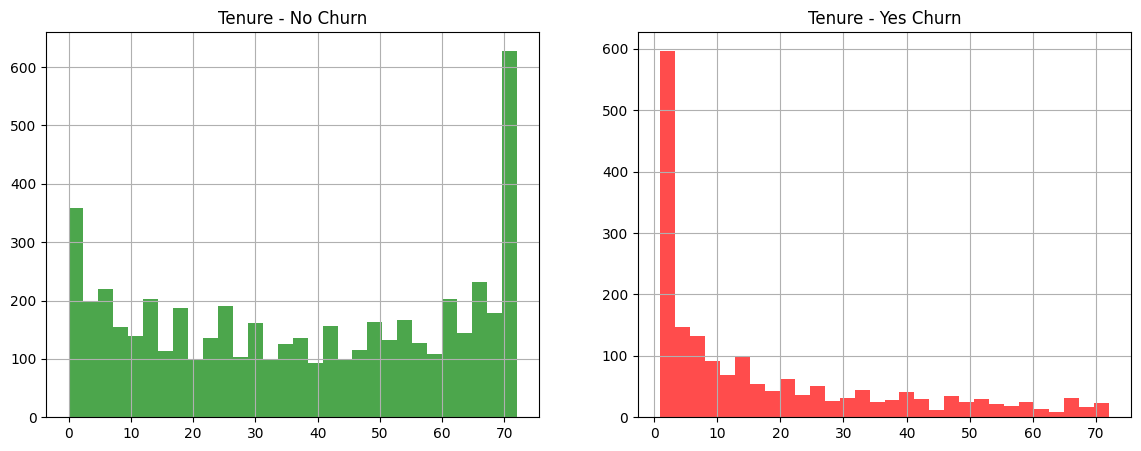

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[df['Churn']=='No']['tenure'].hist(bins=30, ax=axes[0], color='green', alpha=0.7)
axes[0].set_title('Tenure - No Churn')

df[df['Churn']=='Yes']['tenure'].hist(bins=30, ax=axes[1], color='red', alpha=0.7)
axes[1].set_title('Tenure - Yes Churn')

plt.show()

Vemos cómo cuanto más tiempo lleva el cliente con la empresa, menor es la tasa de Churn, la cual es especialmente alta únicamente para aquellos clientes que llevan menos de 3 meses.

### Análisis de correlaciones entre Churn y variables categóricas

In [16]:
from scipy.stats import chi2_contingency

def v_cramer(x,y):
    tabla = pd.crosstab(x,y)
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()

    return np.sqrt(chi2 / (n * (min(tabla.shape) - 1)))

cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
            'PhoneService', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod']

correlaciones = {}
for col in cat_cols:
    correlaciones[col] = v_cramer(df[col], df['Churn'])

corr_ordenadas = sorted(correlaciones.items(), key=lambda x: x[1], reverse=True)

print("Correlación con Churn (V de Cramér):")
for var, valor in corr_ordenadas:
    print(f"{var:<20} {valor:.3f}")



Correlación con Churn (V de Cramér):
Contract             0.410
OnlineSecurity       0.347
TechSupport          0.343
InternetService      0.322
PaymentMethod        0.303
OnlineBackup         0.292
DeviceProtection     0.282
StreamingMovies      0.231
StreamingTV          0.231
PaperlessBilling     0.191
Dependents           0.164
SeniorCitizen        0.150
Partner              0.150
MultipleLines        0.040
PhoneService         0.011
gender               0.008


Detectamos que variables como el **tipo de contrato**, la **seguridad online** o el **soporte técnico** influye mucho en la tasa de abandono, mientras que el **género**, el **servicio telefónico** o la **multplicidad de líneas** no influyen en gran medida.

### Análisis de correlación entre variables categóricas
El objetivo será el de identificar variables que aporten información similar entre ellas, para posteriormente tartarlas y evitar redundancia.

In [17]:
# Filtramos las variables que tienen correlación mayor a 0.1

df_corr = pd.DataFrame(corr_ordenadas, columns = ['Variable', 'Correlación'])

variables_corr_churn = df_corr[df_corr['Correlación'] > 0.1]
variables_corr_churn

,Variable,Correlación
0,Contract,0.410116
1,OnlineSecurity,0.347400
2,TechSupport,0.342916
3,InternetService,0.322455
4,PaymentMethod,0.303359
5,OnlineBackup,0.292316
6,DeviceProtection,0.281580
7,StreamingMovies,0.230951
8,StreamingTV,0.230502
9,PaperlessBilling,0.191498


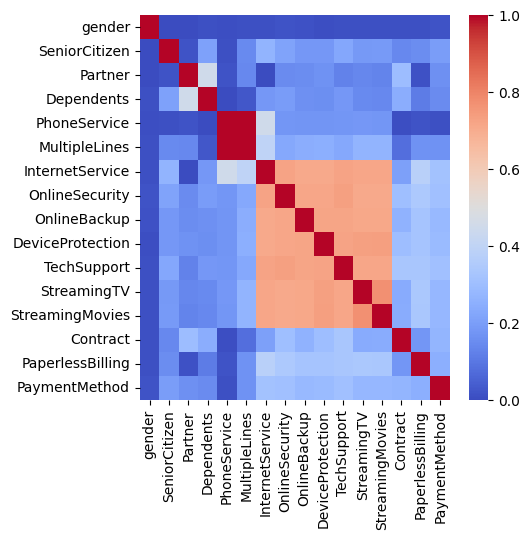

In [18]:
# Crear matriz vacía
matriz = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float) 
# Rellenar matriz con V de Cramér
for col1 in cat_cols:
    for col2 in cat_cols:
        matriz.loc[col1, col2] = v_cramer(df[col1], df[col2])

# Mapa de calor

plt.figure(figsize=(5,5))
sns.heatmap(matriz, annot = False, cmap = 'coolwarm', vmin = 0, vmax = 1)
plt.show()

Observamos que las variables **InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV y StreamingMovies** están fuertemente correlacionadas.

## Conclusiones
- La variable Total Charges está en formato string en vez de int, por lo que habrá que transformarla.
- Existen 11 nulos en la variable Total Charges, por lo que habrá que decidir cómo tratarlos.
- No existen duplicados.
- No hay outliers evidentes en nuestro dataframe.
- Existen 7 variables categóricas altamente correlacionadas, habrá que decidir qué hacer con ellas a la hora de limpiar el dataset.